# YOLOv4

In [1]:
cd /kaggle/working

/kaggle/working


In [2]:
cp -r ../input/mishhh/mish-cuda-master ./mish-cuda

In [3]:
cd mish-cuda

/kaggle/working/mish-cuda


In [4]:
!python setup.py build install

/opt/conda/lib/python3.7/distutils/extension.py:131: UserWarning: Unknown Extension options: 'headers'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/mish_cuda
copying src/mish_cuda/__init__.py -> build/lib.linux-x86_64-3.7/mish_cuda
running egg_info
creating src/mish_cuda.egg-info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.txt
writing manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
reading manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
writing manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
running build_ext
building 'mish_cuda._C' extension
creating /kaggle/working/mish-cuda/build/temp.linux-x86_64-3.7
creating /kaggle/working/mish-cuda/build/temp.linux-x86_64-3.7/csrc
creating /kaggle/working/mish

In [5]:
cd ..

/kaggle/working


In [6]:
cp -r ../input/yolov4-csp ./yolov4

In [7]:
cd yolov4

/kaggle/working/yolov4


In [8]:
import pandas as pd
test_df = pd.read_csv('../../input/global-wheat-detection/' + 'sample_submission.csv')
image_ids = test_df['image_id'].unique()

path = 'test/'
datasets = []
for idx in image_ids:
    if not idx.endswith('.txt'):
        img_path = path  + idx + '.jpg'
        datasets.append(img_path)

with open('./data/test.txt', 'w') as f:
    f.write('\n'.join(datasets))

In [9]:
mkdir test

In [10]:
cp -r ../../input/global-wheat-detection/test/*jpg ./test

In [11]:

!python3 mytest.py --weights ../../input/42-e87/60_163.pt \
	        --data data/wheat.yaml \
		--img-size 1024 \
		--data data/wheat.yaml \
		--cfg models/yolov4-csp_1024.cfg \
		--batch-size 30 \
		--augment \
		--device 0 \
		--names yolov4-csp \
		--task test \
		--conf 0.6 \
		--merge

Namespace(augment=True, batch_size=30, cfg='models/yolov4-csp_1024.cfg', conf_thres=0.6, data='data/wheat.yaml', device='0', img_size=1024, iou_thres=0.65, merge=True, names='yolov4-csp', save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['../../input/42-e87/60_163.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 342 layers, 5.2496e+07 parameters, 5.2496e+07 gradients
Scanning images: 100%|█████████████████████████| 10/10 [00:00<00:00, 510.66it/s]
Scanning labels test.cache (0 found, 0 missing, 10 empty, 0 duplicate, for 10 im
               Class      Images     Targets           P           R      mAP@.52fd875eaa
348a992bb
51b3e36ab
51f1be19e
53f253011
796707dd7
aac893a91
cb8d261a3
cc3532ff6
f5a1f0358
               Class      Images     Targets           P           R      mAP@.5


In [12]:
cd ..

/kaggle/working


In [13]:
cp ./yolov4/submission.csv ./submission_yolov4.csv

In [14]:
pwd

'/kaggle/working'

# YOLOv4 psuedo label

In [15]:
cd yolov4

/kaggle/working/yolov4


In [16]:
import csv
def submission2traincsv(subcsv, outcsv):
    out_list = []
    with open(subcsv, newline='') as csv_file:
        rows = csv.DictReader(csv_file)
        for row in rows:
            imgname = row['image_id']
            #img = Image.open(img_folder + imgname + '.jpg').convert('RGB')
            #imgw, imgh = img.size
            imgw, imgh = 1024, 1024
            print(len(row['PredictionString'].split(' ')))
            boxlen = int(len(row['PredictionString'].split(' ')))
            while boxlen % 5 != 0:
                boxlen = boxlen - 1
            for i in range(0, boxlen, 5):
                xmin = int(row['PredictionString'].split(' ')[i+1])
                ymin = int(row['PredictionString'].split(' ')[i+2])
                w = int(row['PredictionString'].split(' ')[i+3])
                h = int(row['PredictionString'].split(' ')[i+4])
                bbox_strings = [xmin, ymin, w, h]
                result = {
                    'image_id': imgname,
                    'width': imgw,
                    'height': imgh,
                    'bbox': bbox_strings,
                    'source':'train'
                }
                out_list.append(result)
    test_df = pd.DataFrame(out_list, columns=['image_id', 'width', 'height', 'bbox', 'source'])
    test_df.to_csv(outcsv, index=False)

In [17]:
import glob
def combineCSV(csvpath, outcsv):
    csvfile = glob.glob(csvpath + '/*.csv')
    combined_csv = pd.concat([pd.read_csv(f) for f in csvfile])
    combined_csv.to_csv(outcsv, index=False)


In [18]:
submission2traincsv('submission.csv', 'pseudo_label.csv')

120
180
120
85
145
115
105
115
135
140


In [19]:
cp '../../input/global-wheat-detection/train.csv' ./

In [20]:
combineCSV('./', 'combine.csv')

In [21]:
mkdir yolo_data

In [22]:
cp -r  ../../input/global-wheat-detection/test/*jpg ./yolo_data/

In [23]:
import os
import numpy as np
import re
import random
train_img = "yolo_data"
train_annotation = "../input/global-wheat-detection/train"
yolo_path = "yolo_data/"
write_train_txt = './data/train.txt'
write_val_txt = './data/val.txt'

if not os.path.exists(yolo_path):
        os.mkdir(yolo_path)


if os.path.exists(write_train_txt):
    file=open(write_train_txt, 'w')

if os.path.exists(write_val_txt):
    file=open(write_val_txt, 'w')
    
train_df = pd.read_csv('pseudo_label.csv')
train_df['x'], train_df['y'], train_df['w'], train_df['h'] = -1, -1, -1, -1
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
#print(type(train_df['image_id'].unique()))
#image_ids = np.random.choice(train_df['image_id'].unique(), 6000)
img_w = 1024
img_h = 1024
#'''
for img_name in image_ids:

    #img = cv2.imread('./yolo_data/' + img_name + '.jpg')
    #img_h, img_w = img.shape[:2]
    img_path = os.path.join(train_img, img_name)
    df = train_df[train_df['image_id'].isin([img_name])]   
    i = 0
    img_info = []
    for index, row in df.iterrows():
        xmin = row['x']
        ymin = row['y']
        raww = row['w']
        rawh = row['h']

        x = (xmin + (raww/2)) * 1.0 / img_w
        y = (ymin + (rawh/2)) * 1.0 / img_h
        w = raww * 1.0 / img_w
        h = rawh * 1.0 / img_h 
        objclass = 0
        img_info.append(' '.join([str(objclass), str(x),str(y),str(w),str(h)]))

    with open(yolo_path + str(img_name) + '.txt', 'w') as f:
        f.write('\n'.join(img_info))
        
print('the file is processed')

# create train and val txt
path = train_img#os.path.join(train_img, yolo_path)
datasets = []
for idx in image_ids:
    if not idx.endswith('.txt'):
        path = train_img + '/' + idx + '.jpg'
        datasets.append(path)

with open(write_train_txt, 'a') as f:
    f.write('\n'.join(datasets))

with open(write_val_txt, 'a') as f:
    f.write('\n'.join(datasets))

the file is processed


In [24]:
!python train.py --device 0 \
	--img 1024 \
	--data data/wheat.yaml \
	--cfg models/yolov4-csp_1024.cfg \
	--weights ../../input/42-e87/60_163.pt \
	--name yolov4-csp \
	--batch-size 6 \
	--notest \
	--single-cls \
	--cache-images \
	--epochs 3 \
	--hyp ../../input/hyp-fine-tune/hyp_fine_tune.yaml


Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Namespace(adam=False, batch_size=6, bucket='', cache_images=True, cfg='models/yolov4-csp_1024.cfg', data='data/wheat.yaml', device='0', epochs=3, evolve=False, global_rank=-1, hyp='../../input/hyp-fine-tune/hyp_fine_tune.yaml', img_size=[1024, 1024], local_rank=-1, logdir='runs/', multi_scale=False, name='yolov4-csp', noautoanchor=False, nosave=False, notest=True, rect=False, resume=False, single_cls=True, sync_bn=False, total_batch_size=6, weights='../../input/42-e87/60_163.pt', world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-12-30 15:30:42.375364: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
Hyperparameters {'lr0': 0.0001, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_

In [25]:
!python3 mytest.py --weights ./runs/exp0_yolov4-csp/weights/last_yolov4-csp.pt \
	        --data data/wheat.yaml \
		--img-size 1024 \
		--data data/wheat.yaml \
		--cfg models/yolov4-csp_1024.cfg \
		--batch-size 30 \
		--augment \
		--device 0 \
		--names yolov4-csp \
		--task test \
		--conf 0.60 \
		--merge

Namespace(augment=True, batch_size=30, cfg='models/yolov4-csp_1024.cfg', conf_thres=0.6, data='data/wheat.yaml', device='0', img_size=1024, iou_thres=0.65, merge=True, names='yolov4-csp', save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['./runs/exp0_yolov4-csp/weights/last_yolov4-csp.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 342 layers, 5.2496e+07 parameters, 5.2496e+07 gradients
Scanning labels test.cache (0 found, 0 missing, 10 empty, 0 duplicate, for 10 im
               Class      Images     Targets           P           R      mAP@.52fd875eaa
348a992bb
51b3e36ab
51f1be19e
53f253011
796707dd7
aac893a91
cb8d261a3
cc3532ff6
f5a1f0358
               Class      Images     Targets           P           R      mAP@.5


In [26]:
cd ..

/kaggle/working


In [27]:
cp ./yolov4/submission.csv ./submission_yolov4_pseudo.csv

In [28]:
rm -r yolov4

In [29]:
rm -r mish-cuda

# Faster RCNN

In [30]:
cd /kaggle/working

/kaggle/working


In [31]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image
import torch
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt


In [32]:
DIR_INPUT = '/kaggle/input'
DIR_TRAIN = f'{DIR_INPUT}/global-wheat-detection/train'
DIR_TEST = f'{DIR_INPUT}/global-wheat-detection/test'

In [33]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [34]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [35]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [36]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [37]:
model.load_state_dict(torch.load('../input/fasterrcnn-with-aug/15fasterrcnn_resnet50_fpn.pth'))

model.to(device)
model.eval()
a=1

In [38]:
test_df = pd.read_csv('../input/global-wheat-detection/' + 'sample_submission.csv')
test_path = '../input/global-wheat-detection/test'

def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [39]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [40]:
cp -r ../input/wbfwbf/ensemble_boxes-1.0.4-py3-none-any.whl ./

In [41]:
!pip install ensemble_boxes-1.0.4-py3-none-any.whl

Processing ./ensemble_boxes-1.0.4-py3-none-any.whl


In [42]:
from itertools import product

'''
tta_combinations = [[TTARotate270()],[None],[TTARotate90()],[TTARotate180()],[TTAVerticalFlip(),TTARotate270()],[TTAVerticalFlip(),TTARotate90()],[TTAVerticalFlip()],[TTAHorizontalFlip()] ]
tta_transforms = []
for tta_combination in tta_combinations:
    print([tta_transform for tta_transform in tta_combination if tta_transform])
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
'''
#'''
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]
                               #[TTARotate270(), None]
                              ):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))
#'''

In [43]:
import ensemble_boxes
def make_tta_predictions(images, score_threshold=0.5):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            outputs = model(tta_transform.batch_augment(images.clone()))

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()   
                scores = outputs[i]['scores'].data.cpu().numpy()
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.5, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [44]:
detection_threshold = 0.5
results = []
TTA = True

if TTA:
    for images, image_ids in test_data_loader:
        predictions= make_tta_predictions(images)
        #images = list(image.to(device) for image in images)
        #outputs = model(images)

        for i, image in enumerate(images):
            '''
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            '''
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
                'image_id': image_id,
                'PredictionString': format_prediction_string(boxes, scores)
            }


            results.append(result)
else:
    for images, image_ids in test_data_loader:
        #predictions= make_tta_predictions(images)
        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):
            #'''
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            #'''
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
                'image_id': image_id,
                'PredictionString': format_prediction_string(boxes, scores)
            }


            results.append(result)

/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


In [45]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9940 617 916 77 106 0.9934 67 2 103 158 0.98...
1,51f1be19e,0.9905 612 89 153 169 0.9902 503 474 197 106 0...
2,f5a1f0358,0.9944 941 432 82 188 0.9932 140 752 157 123 0...
3,796707dd7,0.9895 901 333 100 90 0.9889 711 828 103 97 0....
4,51b3e36ab,0.9963 547 28 247 139 0.9962 872 291 150 138 0...


/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


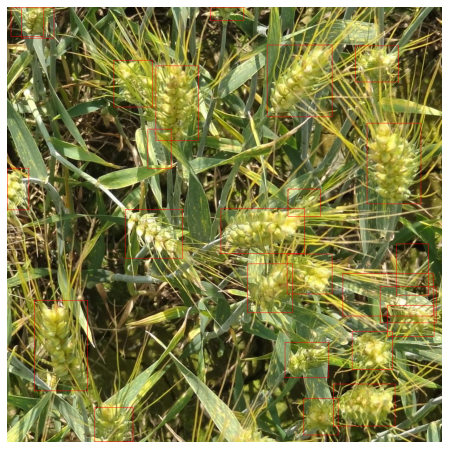

In [46]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(test_data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=1024)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

In [47]:
test_df.to_csv('submission_faster.csv', index=False)

In [48]:
cat submission_faster.csv

image_id,PredictionString
aac893a91,0.9940 617 916 77 106 0.9934 67 2 103 158 0.9870 740 771 76 116 0.9856 595 776 91 120 0.9841 247 89 132 147 0.9840 28 454 99 153 0.9832 696 392 118 177 0.9738 331 668 115 148 0.9729 559 84 131 170 0.9682 180 569 108 182 0.9662 457 856 84 102 0.9646 357 531 95 85 0.9644 558 535 121 188 0.9617 817 698 100 206 0.9593 86 617 120 83 0.9489 236 842 134 92 0.9364 61 854 123 74 0.6974 306 1 67 64 0.6813 362 267 105 152 0.6054 320 868 78 90 0.1516 838 919 99 101 0.1016 385 338 81 83 0.0742 480 983 85 40 0.0649 367 267 75 98
51f1be19e,0.9905 612 89 153 169 0.9902 503 474 197 106 0.9816 278 476 135 115 0.9735 847 273 127 190 0.9718 654 789 103 83 0.9670 768 887 145 99 0.9663 812 763 95 90 0.9431 659 581 106 94 0.9398 350 138 100 176 0.9352 566 604 106 115 0.9330 820 91 101 85 0.9258 64 690 125 213 0.9053 206 942 90 81 0.8986 251 125 91 110 0.8958 34 1 76 72 0.8875 1 379 50 98 0.8740 698 921 81 86 0.5058 895 702 110 73 0.3246 878 658 132 85 0.1784 331 287 55 93 

# YOLOv3

In [49]:
cd /kaggle/working

/kaggle/working


In [50]:
!pip install ../input/mmcvwhl/addict-2.2.1-py3-none-any.whl
!pip install ../input/mmdetection20513/mmcv-0.5.1-cp37-cp37m-linux_x86_64.whl
!pip install ../input/mmdetection20513/terminal-0.4.0-py3-none-any.whl
!pip install ../input/mmdetection20513/terminaltables-3.1.0-py3-none-any.whl

Processing /kaggle/input/mmcvwhl/addict-2.2.1-py3-none-any.whl
Processing /kaggle/input/mmdetection20513/mmcv-0.5.1-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/mmdetection20513/terminal-0.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetection20513/terminaltables-3.1.0-py3-none-any.whl
terminaltables is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [51]:
!cp -r ../input/mmdetection/mmdetection .

In [52]:
cd mmdetection

/kaggle/working/mmdetection


In [53]:
!cp -r ../../input/cocoapi/cocoapi .

In [54]:
cd cocoapi/PythonAPI

/kaggle/working/mmdetection/cocoapi/PythonAPI


In [55]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/mmdetection/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -I../common -I/opt/conda/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7

In [56]:
!make install

# install pycocotools to the Python site-packages
python setup.py build_ext install
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -I../common -I/opt/conda/include/python3.7m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.7/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:7: warning: this ‘for’ clause does not guard... [-Wmisleading-indentation]
       for( k=0; k<R[i].cnts[j]; k++ ) *(M++)=v; v=!v; }}
       ^~~
../common/maskApi.c:46:49: note: ...this statement, but the latter is misleadingly indented as if it were guarded b

In [57]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.7/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.7/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.7
creatin

In [58]:
import pycocotools

In [59]:
cd ../..

/kaggle/working/mmdetection


In [60]:
!pip install ../../input/torchwhl/torch-1.7.1-cp37-cp37m-linux_x86_64.whl
!pip install ../../input/torchwhl/torchvision-0.8.2-cp37-cp37m-linux_x86_64.whl
!pip install ../../input/torchwhl/torchaudio-0.7.2-cp37-cp37m-linux_x86_64.whl
!pip install ../../input/mmcvwhl/mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl

Processing /kaggle/input/torchwhl/torch-1.7.1-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
Processing /kaggle/input/torchwhl/torchvision-0.8.2-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
Processing /kaggle/input/torchwhl/torchaudio-0.7.2-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.7.0a0+ac17b64
    Uninstalling torchaudio-0.7.0a0+ac17b64:
      Successfully uninstalled torchaudio-0.7.0a0+ac17b64
Processing /kaggle/input/mmcvwhl/mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl


In [61]:
!pip install -v -e .

Using pip 20.3.1 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-ephem-wheel-cache-dpej7txo
Created temporary directory: /tmp/pip-req-tracker-j5i0njwj
Initialized build tracking at /tmp/pip-req-tracker-j5i0njwj
Created build tracker: /tmp/pip-req-tracker-j5i0njwj
Entered build tracker: /tmp/pip-req-tracker-j5i0njwj
Created temporary directory: /tmp/pip-install-htatj_0o
Obtaining file:///kaggle/working/mmdetection
  Added file:///kaggle/working/mmdetection to build tracker '/tmp/pip-req-tracker-j5i0njwj'
    Running setup.py (path:/kaggle/working/mmdetection/setup.py) egg_info for package from file:///kaggle/working/mmdetection
    Created temporary directory: /tmp/pip-pip-egg-info-uwedyyqg
    Running command python setup.py egg_info
    running egg_info
    creating /tmp/pip-pip-egg-info-uwedyyqg/mmdet.egg-info
    writing /tmp/pip-pip-egg-info-uwedyyqg/mmdet.egg-info/PKG-INFO
    writi

In [62]:
!pip install ../../input/mmcvwhl/mmcv_full-1.2.1torch1.7.0cu102-cp37-cp37m-manylinux1_x86_64.whl

Processing /kaggle/input/mmcvwhl/mmcv_full-1.2.1torch1.7.0cu102-cp37-cp37m-manylinux1_x86_64.whl


In [63]:
cd ..

/kaggle/working


In [64]:
mkdir result

In [65]:
cd mmdetection

/kaggle/working/mmdetection


In [66]:
!cp -r ../../input/convert/utils.py ../

In [67]:
from utils import testJson
testJson('../testCOCO.json', '../../input/global-wheat-detection/sample_submission.csv', '../../input/global-wheat-detection/test/')

In [68]:
!python tools/test.py \
        configs/wheat/pre_yolov3_1024_norm.py \
        ../../input/weights/gamma_pre_epo33_norm_yolov3_1024_43.pth \
        --format-only \
        --options "jsonfile_prefix=../result/yolov3"

tools/test.py:99: UserWarning: --options is deprecated in favor of --eval-options
  warnings.warn('--options is deprecated in favor of --eval-options')
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 7.4 task/s, elapsed: 1s, ETA:     0s

In [69]:
cd ..

/kaggle/working


In [70]:
from utils import mmForm2SubmitForm
mmForm2SubmitForm('./result/yolov3.bbox.json', './testCOCO.json', 'submission_yolov3.csv')

In [71]:
!rm -r mmdetection/*
!rm -r result/*
!rm utils.py
!rm -r mmdetection
!rm -r result

# Weighted Boxes Fusion

In [72]:
cd /kaggle/working

/kaggle/working


In [73]:
!cp -r ../input/ensemble/ensemble_boxes_wbf.py .

In [74]:
import csv
import operator
from ensemble_boxes_wbf import *

In [75]:
import csv
import operator
from ensemble_boxes_wbf import *

def conbine(subcsv1, outcsv):
    out_list = []
    csv1 = open(subcsv1)
    next(csv1)
    rows1 = csv.reader(csv1)
    sortedrow1 = sorted(rows1, key=operator.itemgetter(0))
    image_size = 1024
    for row1 in sortedrow1:
        imgname = row1[0]
        bbox_strings1 = []
        score1 = []
        label1 = []
        pred_strings = []
        boxlen = int(len(row1[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score1.append(float(row1[1].split(' ')[i]))
            w = int(row1[1].split(' ')[i+3])
            h = int(row1[1].split(' ')[i+4])
            xmin = int(row1[1].split(' ')[i+1])
            ymin = int(row1[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings1.append([xmin / (image_size-1), ymin / (image_size-1), xmax / (image_size-1), ymax / (image_size-1)])
            label1.append(1)

        score = [score1]
        boxes_list = [bbox_strings1]
        label = [label1]
        
        iou_thr = 0.5
        skip_box_thr = 0.4
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, score, label, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        for i in range(len(scores)):
            xmin = int(boxes[i][0] * (image_size-1))
            ymin = int(boxes[i][1] * (image_size-1))
            w = int((boxes[i][2] - boxes[i][0]) * (image_size-1))
            h = int((boxes[i][3] - boxes[i][1]) * (image_size-1))
            pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(scores[i], xmin, ymin, w, h))

        result = {
                'image_id': imgname,
                'PredictionString': " ".join(pred_strings)
        }
        out_list.append(result)

    test_df = pd.DataFrame(out_list, columns=['image_id', 'PredictionString'])
    test_df.to_csv(outcsv, index=False)

In [76]:
def conbine2(subcsv1, subcsv2, outcsv):
    img_size = 1024
    out_list = []
    csv1 = open(subcsv1)
    csv2 = open(subcsv2)
    next(csv1)
    next(csv2)
    rows1 = csv.reader(csv1)
    rows2 = csv.reader(csv2)
    sortedrow1 = sorted(rows1, key=operator.itemgetter(0))
    sortedrow2 = sorted(rows2, key=operator.itemgetter(0))
    for row1, row2 in zip(sortedrow1, sortedrow2):
        imgname = row1[0]
        bbox_strings1 = []
        bbox_strings2 = []
        score1 = []
        score2 = []
        label1 = []
        label2 = []
        pred_strings = []
        boxlen = int(len(row1[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score1.append(float(row1[1].split(' ')[i]))
            w = int(row1[1].split(' ')[i+3])
            h = int(row1[1].split(' ')[i+4])
            xmin = int(row1[1].split(' ')[i+1])
            ymin = int(row1[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings1.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label1.append(1)
        
        boxlen = int(len(row2[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):    
            score2.append(float(row2[1].split(' ')[i]))
            w = int(row2[1].split(' ')[i+3])
            h = int(row2[1].split(' ')[i+4])
            xmin = int(row2[1].split(' ')[i+1])
            ymin = int(row2[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings2.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label2.append(1)

        score = [score1, score2]
        boxes_list = bbox_strings1, bbox_strings2
        label = [label1, label2]
        weights = [8, 2]
        
        iou_thr = 0.5
        skip_box_thr = 0.0001
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, score, label, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        for i in range(len(scores)):
            xmin = int(boxes[i][0] * (img_size-1))
            ymin = int(boxes[i][1] * (img_size-1))
            w = int((boxes[i][2] - boxes[i][0]) * (img_size-1))
            h = int((boxes[i][3] - boxes[i][1]) * (img_size-1))
            pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(scores[i], xmin, ymin, w, h))

        result = {
                'image_id': imgname,
                'PredictionString': " ".join(pred_strings)
        }
        out_list.append(result)

    test_df = pd.DataFrame(out_list, columns=['image_id', 'PredictionString'])
    test_df.to_csv(outcsv, index=False)

In [77]:
def conbine3(subcsv1, subcsv2, subcsv3, outcsv):
    img_size = 1024
    out_list = []
    csv1 = open(subcsv1)
    csv2 = open(subcsv2)
    csv3 = open(subcsv3)
    next(csv1)
    next(csv2)
    next(csv3)
    rows1 = csv.reader(csv1)
    rows2 = csv.reader(csv2)
    rows3 = csv.reader(csv3)
    sortedrow1 = sorted(rows1, key=operator.itemgetter(0))
    sortedrow2 = sorted(rows2, key=operator.itemgetter(0))
    sortedrow3 = sorted(rows3, key=operator.itemgetter(0))
    for row1, row2, row3 in zip(sortedrow1, sortedrow2, sortedrow3):
        imgname = row1[0]
        bbox_strings1 = []
        bbox_strings2 = []
        bbox_strings3 = []
        score1 = []
        score2 = []
        score3 = []
        label1 = []
        label2 = []
        label3 = []
        pred_strings = []
        boxlen = int(len(row1[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score1.append(float(row1[1].split(' ')[i]))
            w = int(row1[1].split(' ')[i+3])
            h = int(row1[1].split(' ')[i+4])
            xmin = int(row1[1].split(' ')[i+1])
            ymin = int(row1[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings1.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label1.append(1)
            
        boxlen = int(len(row2[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):      
            score2.append(float(row2[1].split(' ')[i]))
            w = int(row2[1].split(' ')[i+3])
            h = int(row2[1].split(' ')[i+4])
            xmin = int(row2[1].split(' ')[i+1])
            ymin = int(row2[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings2.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label2.append(1)
            
        boxlen = int(len(row3[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score3.append(float(row3[1].split(' ')[i]))
            w = int(row3[1].split(' ')[i+3])
            h = int(row3[1].split(' ')[i+4])
            xmin = int(row3[1].split(' ')[i+1])
            ymin = int(row3[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings3.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label3.append(1)

        score = [score1, score2, score3]
        boxes_list = bbox_strings1, bbox_strings2, bbox_strings3
        label = [label1, label2, label3]
        weights = [8, 4, 2]
        
        iou_thr = 0.475
        skip_box_thr = 0.41
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, score, label, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        for i in range(len(scores)):
            xmin = int(boxes[i][0] * (img_size-1))
            ymin = int(boxes[i][1] * (img_size-1))
            w = int((boxes[i][2] - boxes[i][0]) * (img_size-1))
            h = int((boxes[i][3] - boxes[i][1]) * (img_size-1))
            pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(scores[i], xmin, ymin, w, h))

        result = {
                'image_id': imgname,
                'PredictionString': " ".join(pred_strings)
        }
        out_list.append(result)

    test_df = pd.DataFrame(out_list, columns=['image_id', 'PredictionString'])
    test_df.to_csv(outcsv, index=False)

In [78]:
def conbine4(subcsv1, subcsv2, subcsv3, subcsv4, outcsv):
    img_size = 1024
    out_list = []
    csv1 = open(subcsv1)
    csv2 = open(subcsv2)
    csv3 = open(subcsv3)
    csv4 = open(subcsv4)
    next(csv1)
    next(csv2)
    next(csv3)
    next(csv4)
    rows1 = csv.reader(csv1)
    rows2 = csv.reader(csv2)
    rows3 = csv.reader(csv3)
    rows4 = csv.reader(csv4)
    sortedrow1 = sorted(rows1, key=operator.itemgetter(0))
    sortedrow2 = sorted(rows2, key=operator.itemgetter(0))
    sortedrow3 = sorted(rows3, key=operator.itemgetter(0))
    sortedrow4 = sorted(rows4, key=operator.itemgetter(0))
    for row1, row2, row3, row4 in zip(sortedrow1, sortedrow2, sortedrow3, sortedrow4):
        imgname = row1[0]
        bbox_strings1 = []
        bbox_strings2 = []
        bbox_strings3 = []
        bbox_strings4 = []
        score1 = []
        score2 = []
        score3 = []
        score4 = []
        label1 = []
        label2 = []
        label3 = []
        label4 = []
        pred_strings = []
        boxlen = int(len(row1[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score1.append(float(row1[1].split(' ')[i]))
            w = int(row1[1].split(' ')[i+3])
            h = int(row1[1].split(' ')[i+4])
            xmin = int(row1[1].split(' ')[i+1])
            ymin = int(row1[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings1.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label1.append(1)
            
        boxlen = int(len(row2[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):      
            score2.append(float(row2[1].split(' ')[i]))
            w = int(row2[1].split(' ')[i+3])
            h = int(row2[1].split(' ')[i+4])
            xmin = int(row2[1].split(' ')[i+1])
            ymin = int(row2[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings2.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label2.append(1)
            
        boxlen = int(len(row3[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score3.append(float(row3[1].split(' ')[i]))
            w = int(row3[1].split(' ')[i+3])
            h = int(row3[1].split(' ')[i+4])
            xmin = int(row3[1].split(' ')[i+1])
            ymin = int(row3[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings3.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label3.append(1)

        boxlen = int(len(row4[1].split(' ')))
        while boxlen % 5 != 0:
            boxlen = boxlen - 1
        for i in range(0, boxlen, 5):
            score4.append(float(row4[1].split(' ')[i]))
            w = int(row4[1].split(' ')[i+3])
            h = int(row4[1].split(' ')[i+4])
            xmin = int(row4[1].split(' ')[i+1])
            ymin = int(row4[1].split(' ')[i+2])
            xmax = (xmin + w)
            ymax = (ymin + h)
            bbox_strings4.append([xmin / (img_size-1), ymin / (img_size-1), xmax / (img_size-1), ymax / (img_size-1)])
            label4.append(1)
            
        score = [score1, score2, score3, score4]
        boxes_list = bbox_strings1, bbox_strings2, bbox_strings3, bbox_strings4
        label = [label1, label2, label3, label4]
        weights = [16, 16, 4, 2]
        
        iou_thr = 0.44
        skip_box_thr = 0.43
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, score, label, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        for i in range(len(scores)):
            xmin = int(boxes[i][0] * (img_size-1))
            ymin = int(boxes[i][1] * (img_size-1))
            w = int((boxes[i][2] - boxes[i][0]) * (img_size-1))
            h = int((boxes[i][3] - boxes[i][1]) * (img_size-1))
            pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(scores[i], xmin, ymin, w, h))

        result = {
                'image_id': imgname,
                'PredictionString': " ".join(pred_strings)
        }
        out_list.append(result)

    test_df = pd.DataFrame(out_list, columns=['image_id', 'PredictionString'])
    test_df.to_csv(outcsv, index=False)

In [79]:
# conbine2('./submission_yolov4.csv', './submission_faster.csv', './submission.csv')
# !rm ./submission_yolov4.csv
# !rm ./submission_faster.csv
# !rm ./ensemble_boxes_wbf.py
# !rm ./ensemble_boxes-1.0.4-py3-none-any.whl

In [80]:
# conbine('./submission_yolov4.csv', './submission_yolov4.csv')
# conbine('./submission_yolov3.csv', './submission_yolov3.csv')
# conbine3('./submission_yolov4.csv', './submission_faster.csv', './submission_yolov3.csv', './submission.csv')
# !rm ./submission_yolov4.csv
# !rm ./submission_faster.csv
# !rm ./submission_yolov3.csv
# !rm ./testCOCO.json
# !rm ./ensemble_boxes_wbf.py
# !rm ./ensemble_boxes-1.0.4-py3-none-any.whl

In [81]:
conbine('./submission_yolov4.csv', './submission_yolov4.csv')
conbine('./submission_yolov3.csv', './submission_yolov3.csv')
conbine('./submission_yolov4_pseudo.csv', './submission_yolov4_pseudo.csv')
conbine4('./submission_yolov4_pseudo.csv', './submission_yolov4.csv', './submission_faster.csv', './submission_yolov3.csv', './submission.csv')
!rm ./submission_yolov4.csv
!rm ./submission_faster.csv
!rm ./submission_yolov3.csv
!rm ./submission_yolov4_pseudo.csv
!rm ./testCOCO.json
!rm ./ensemble_boxes_wbf.py
!rm ./ensemble_boxes-1.0.4-py3-none-any.whl

/kaggle/working/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/kaggle/working/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/kaggle/working/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/kaggle/working/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/kaggle/working/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that yo